In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import os
sys.path.append("../")
from search_world.utils.analysis_utils import get_trials_dataframe, get_dataset_paths, get_trials_features, get_consistency, get_condition_df, get_condition_features
from search_world.utils.moog_utils import get_trial_paths, get_trial_dataframe
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors
import pandas as pd
%matplotlib inline

Loading in agent data

In [188]:
base_dir = '../logs'

all_job_ids = [f for f in os.scandir(base_dir) if f.is_dir() and f.path != os.path.join(base_dir,'slurm_logs')]
agent_df = get_trials_features(get_trials_dataframe(get_dataset_paths(job_ids=all_job_ids, base_dir=''), overwrite=False))
# condition_df = get_condition_features(get_condition_df(df, condition=['length', 'n_corr', 'agent_init_state', 'target_state']), df)
# consistency_df = get_consistency(condition_df, df, condition=['length', 'n_corr', 'agent_init_state', 'target_state'])

Loading in human data

In [3]:
human_base_dir = '../human_logs'
dataset_paths = ['../human_logs/symm_corr/2/2021_11_11_10_47_01', '../human_logs/symm_corr/2/2021_11_11_15_38_19']

dataset_trial_paths = []
for i, path in enumerate(dataset_paths): 
    trial_paths = get_trial_paths(path)
    dataset_trial_paths.append(trial_paths)

dataset_index = 0
trial_df = []
for trial_paths in dataset_trial_paths:
    dataset_index += 1
    new_df =  get_trial_dataframe(trial_paths, dataset_index=dataset_index)
    trial_df.append(new_df)

trial_df = pd.concat(trial_df)
human_df = get_trials_features(trial_df)
human_df = human_df[agent_df.columns]

Number of trials:  53
Number of trials:  93


IndexError: index 0 is out of bounds for axis 0 with size 0

Concatenating human and agent data into a single dataframe, find consistency scores

In [178]:
df = pd.concat((agent_df, human_df))
condition_df = get_condition_features(get_condition_df(df, condition=['length', 'n_corr', 'agent_init_state', 'target_state']), df)
consistency_df = get_consistency(condition_df, df, condition=['length', 'n_corr', 'agent_init_state', 'target_state'])

/home/apiccato/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


# Condition counts across agents

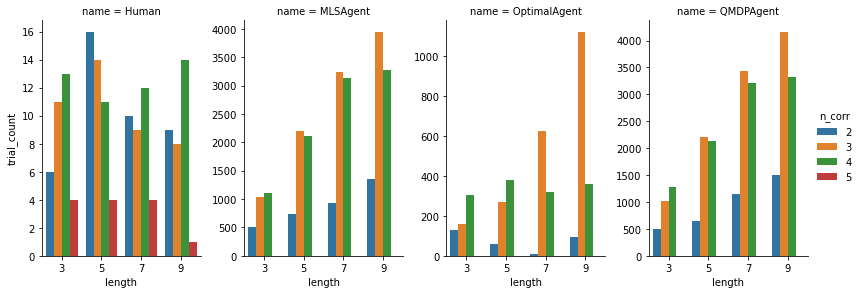

In [179]:
condition_count = df.groupby(['length', 'n_corr', 'name'])['trial_index'].count().to_frame().reset_index().rename(columns={'trial_index':'trial_count'})
g = sns.catplot(x="length", y="trial_count",
                hue="n_corr", col="name",
                data=condition_count, kind="bar",
                height=4, aspect=.7, sharey=False)
plt.show()

# Consistency across agents

In [181]:
consistency_df

name,Human,MLSAgent,QMDPAgent
name,,,
Human,NaN,-0.080395,-0.041079
MLSAgent,-0.080395,0.881273,0.233627
QMDPAgent,-0.041079,0.233627,0.945678


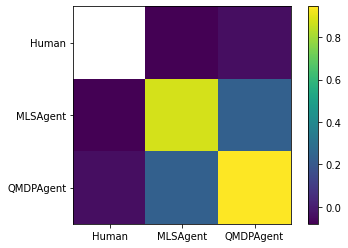

In [182]:
%matplotlib inline
f, ax = plt.subplots(1, 1)
im = ax.imshow(consistency_df)

ax.set_xticks(np.arange(len(consistency_df.columns)))
ax.set_yticks(np.arange(len(consistency_df.columns)))
ax.set_xticklabels(consistency_df.columns)
ax.set_yticklabels(consistency_df.columns)
plt.colorbar(im)
plt.show()

## MLS-QMDP

In [713]:
%matplotlib widget
mls_df = condition_df[condition_df.index.get_level_values('name') == 'MLSAgent'].reset_index().set_index(condition)
qmdp_df = condition_df[condition_df.index.get_level_values('name') == 'QMDPAgent'].reset_index().set_index(condition)
merged = mls_df.merge(qmdp_df, on=condition, suffixes=['_mls', '_qmdp'])
conditions = merged.index
f, ax = plt.subplots(1, 1)
f.suptitle('MLS-QMDP consistency')
sc = sns.scatterplot(data=merged, x="error_mls", y="error_qmdp", ax=ax)

cursor = mplcursors.cursor(sc, hover=True)
# # by default the annotation displays the xy positions
# # this is to change it to the countries name
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text="length=%d, n_corr=%d, agent_init_pos=%d, target_pos=%d"%(conditions[sel.index]))

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …